In [1]:
import skvideo.io
import skimage.io
from skimage import color,exposure,transform,filters
import skvideo.datasets
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from time import time
import sklearn

In [2]:
def frameCountError(reader,n):
    # get total number of frames in the video
    T = reader.getShape()[0]
    # give error if n>T
    if n>T:
        reader.close()
        raise ValueError("n should be less than or equal to %i, the total number frames in the video"%T)

# Algorithm 2

The only difference between algo 1 and 2 is taking a transformation of the same frame instead of getting the next frame as a reference to get interest points and so on.

![](Algo2.svg)

Define some transfer functions

In [3]:
tf1 = lambda frame: np.rot90(frame).reshape(frame.shape)
tf2 = lambda frame: np.transpose(np.rot90(frame))
tf3 = lambda frame: frame[::-1,::-1]
tf4 = lambda frame: frame

def tf5(frame):
    s = frame.shape
    return np.concatenate((frame[:,s[1]//2:],frame[:,:s[1]//2]),axis=1)

def tf6(frame):
    s = frame.shape
    return np.concatenate((frame[s[0]//2:,:],frame[:s[0]//2,:]),axis=0)

tf7 = lambda frame: tf5(tf6(frame))
tf8 = lambda frame: tf1(tf2(tf3(frame)))
tfCount = 8
tf = lambda n : eval("tf"+str(n))

To demonstrate the functions of `tf`s let's see what happens to a simple 3 x 3 image by `tf`s.

Original Image


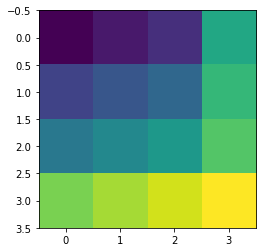

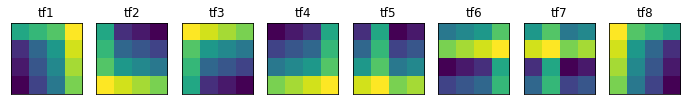

In [6]:
img = np.array([[1,2,3,10],[4,5,6,11],[7,8,9,12],[13,14,15,16]])
print("Original Image")
plt.imshow(img);plt.show()
fig, axes = plt.subplots(1,tfCount, figsize=(12, 6),
                         subplot_kw={'xticks': [], 'yticks': []})
tf_method = ["tf%i"%i for i in range(1,tfCount+1,1)]
i = 1
for ax, tf_method in zip(axes.flat, tf_method):
    ax.imshow(tf(i)(img));ax.set_title(tf_method);i+=1
plt.show()

In [4]:
def getChangeTf(frame,plane,tf):
    """
        this gives 3 outputs regarding the specified plane of rFrame and frame
        inc: 
        dec:
        incdec:
    """
    frame = frame[:,:,plane]
    # this is the transformation done:
    rFrame = tf(frame)
    
    inc = (rFrame>frame)
    dec =  (rFrame<frame)
    incdec = np.logical_or(inc, dec)
    
    return np.array([inc,dec,incdec])

In [5]:
adPath = "D:/Ads/seperate trims/"
ads = [adPath+"ADD_%i.mp4"%i for i in range(1,9,1)]
g_ads = ["g_ad_%i.mp4"%i for i in range(1,9,1)]

In [6]:
def getMatchScoreExtended(vid1,vid2,n):
    """give score using first n frames using same algo
        as getMatchScore.
    """
    reader1 = skvideo.io.FFmpegReader(vid1)
    reader2 = skvideo.io.FFmpegReader(vid2)
    frameCountError(reader1,n+1)
    frameCountError(reader2,n+1)
    out = 0
    for i in range(n):
        frameVid1,frameVid2 = reader1._readFrame(),reader2._readFrame()
        inc1,dec1,incdec1 = getChange(frameVid1,1)
        inc2,dec2,incdec2 = getChange(frameVid2,1)
        interestPoints = np.logical_and(incdec1,incdec2)
        cleanInc1,cleanInc2 = np.logical_and(interestPoints,np.array([inc1,inc2])) 
        incScoreMat = np.logical_xor(cleanInc1,cleanInc2)
        incScore = np.sum(incScoreMat)
        sumInterest = np.sum(interestPoints)
        if incScore:
            out += (sumInterest/(incScore))
    reader1.close()
    reader2.close()
    return out    

In [7]:
def getName(variable):
    for k,v in list(globals().items()):
        if v is variable:
            return k

In [8]:
def stats(data):
    """gives mean and standard deviation of data"""
    mean_data = np.sum(data)/data.size
    std_dev_data = np.sqrt(np.sum((data-mean_data)**2)/data.size)
    return np.array((mean_data,std_dev_data))

In [9]:
def getMatchness(matchFunc,list1,list2,n):
    """This function says how good the matchFunc is."""
    l = []
    for i in range(len(list2)):
        m = []
        for j in range(len(list1)):
            score = matchFunc(list1[j],list2[i],n)
            m.append(score)
        l.append(m)
    l = np.array(l)
    diag = l.diagonal()
    mean_diag,std_dev_diag = stats(diag)
    cv_diag = std_dev_diag/mean_diag
    eye = ~np.eye(l.shape[0],dtype=bool)
    ndiag = eye*l
    mean_ndiag = np.sum(ndiag)/np.sum(eye)
    mean_ndiag_MAT = eye*mean_ndiag
    std_dev_ndiag = np.sqrt(np.sum((ndiag-mean_ndiag)**2)/np.sum(eye))
    cv_ndiag = std_dev_ndiag/mean_ndiag
    print("diagonal mean = {0} \t sd = {1} CV = {2}".format(mean_diag,
                                                std_dev_diag,cv_diag))
    print("ndiag mean = {0} \t sd = {1} CV = {2}".format(mean_ndiag,
                                            std_dev_ndiag,cv_ndiag))
    heatmap = plt.imshow(l, cmap='hot', interpolation='nearest')
    plt.xlabel("%s"%getName(list1))
    plt.ylabel("%s"%getName(list2))
    plt.colorbar(heatmap)
    plt.show()
    return mean_diag, std_dev_diag, cv_diag,mean_ndiag,std_dev_ndiag,cv_ndiag

The `getMatchness` function is improved a little bit to give us some statistical insight, interms of $\mu$, $\sigma$ and coefficient of variation $\left(\frac{\sigma}{\mu}\right)$

tf1:
diagonal mean = 390.1157375412008 	 sd = 338.24758711211746 CV = 0.8670441988421309
ndiag mean = 6.229004837036091 	 sd = 3.974808655162687 CV = 0.6381129504876089


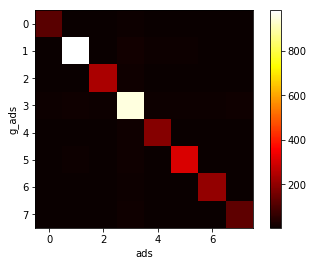

time elapsed: 9.333492755889893
tf2:
diagonal mean = 47.067508511798835 	 sd = 21.676311234323297 CV = 0.46053661899034876
ndiag mean = 2.132861755147592 	 sd = 0.908277848675173 CV = 0.42584937653979404


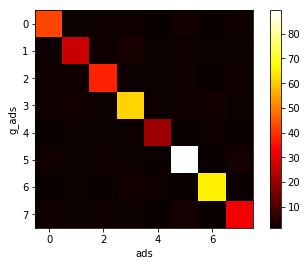

time elapsed: 10.43372917175293
tf3:
diagonal mean = 106.830116981132 	 sd = 60.9913305923469 CV = 0.570918878644671
ndiag mean = 2.2349720536116053 	 sd = 1.0034862769195219 CV = 0.44899276270499094


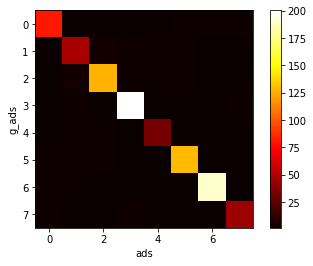

time elapsed: 9.437608480453491
tf4:
diagonal mean = 0.0 	 sd = 0.0 CV = nan
ndiag mean = 0.0 	 sd = 0.0 CV = nan


F:\Softwares\Anaconda\envs\cntk-py35\lib\site-packages\ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in double_scalars
F:\Softwares\Anaconda\envs\cntk-py35\lib\site-packages\ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in double_scalars


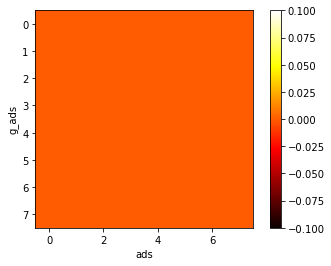

time elapsed: 9.641842365264893
tf5:
diagonal mean = 664.5983610760558 	 sd = 893.2758899764493 CV = 1.3440837990183125
ndiag mean = 21.393814608060868 	 sd = 27.402581871984726 CV = 1.2808646972971265


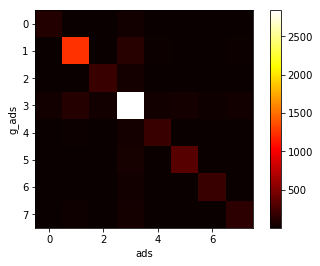

time elapsed: 9.845067024230957
tf6:
diagonal mean = 944.4091914883909 	 sd = 921.9784750809883 CV = 0.9762489431386709
ndiag mean = 19.425516399042262 	 sd = 21.350792501312647 CV = 1.09911067807522


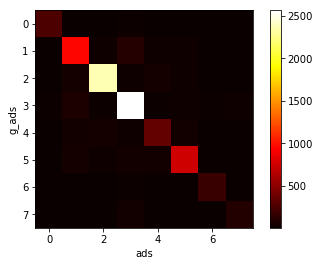

time elapsed: 9.611804723739624
tf7:
diagonal mean = 2833.2500307590094 	 sd = 3483.768632826616 CV = 1.229601551223962
ndiag mean = 34.35587702592728 	 sd = 35.5729286840277 CV = 1.0354248461531619


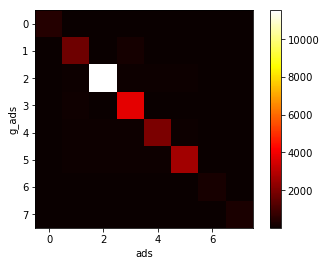

time elapsed: 9.491670608520508
tf8:
diagonal mean = 400.94609571053985 	 sd = 350.2940281945225 CV = 0.8736686351160151
ndiag mean = 6.250426246493455 	 sd = 4.005498333193326 CV = 0.6408360286533172


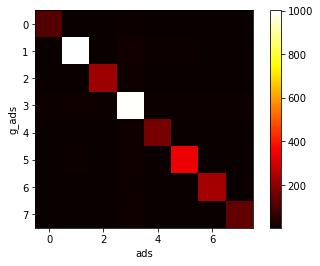

time elapsed: 9.98822808265686


In [16]:
for i in range(1,tfCount+1,1):
    t = time()
    getChange = lambda frame,plane:getChangeTf(frame,plane,tf(i))
    print("tf%i:"%i)
    getMatchness(getMatchScoreExtended,ads,g_ads,1)
    print("time elapsed: "+str(time()-t))

In spite of time elapsed, rotational transformations perform better. Just mixing them won't do good.

Try for another set of videos.

In [10]:
vidPath = "D:/Users/ASUS/Documents/Adobe/Premiere Pro/9.0/"
vids = [vidPath+"ad%i.mp4"%i for i in range(1,9,1)]

Add AWGN to videos.

In [11]:
def addNoise(inputvideo,outputvideo,mu,sigma,n):
    reader = skvideo.io.FFmpegReader(inputvideo)
    writer = skvideo.io.FFmpegWriter(outputvideo)
    frameCountError(reader,n)
    counter = 0
    for frame in reader.nextFrame():
        outputFrame = np.uint8(frame+mu+sigma*np.random.randn(frame.shape[0],frame.shape[1],frame.shape[2]))        
        writer.writeFrame(outputFrame)
        counter += 1
        if counter == n: 
            break
    reader.close()
    writer.close()

In [12]:
def addNoiseArray(inputList,outputList,mu,sigma,n):
    for inputvideo,outputvideo in zip(inputList,outputList):
        addNoise(inputvideo,outputvideo,mu,sigma,n)

`nVids` contains noise with $\sigma=5$

In [13]:
nVids = ["nVid%i.mp4"%i for i in range(1,9,1)]

In [21]:
addNoiseArray(vids,nVids,0,5,130)

`nVids2` contains noise with $\sigma =20$

In [14]:
nVids2 = ["nVid2_%i.mp4"%i for i in range(1,9,1)]

In [23]:
addNoiseArray(vids,nVids2,0,20,130)

Check algo 2 for `vids` and `nVids` for different `tf`s

tf1:
diagonal mean = 6.640269238537701 	 sd = 3.510439505411283 CV = 0.5286592123460857
ndiag mean = 2.2065068122869396 	 sd = 0.8818460707244536 CV = 0.39965708051019433


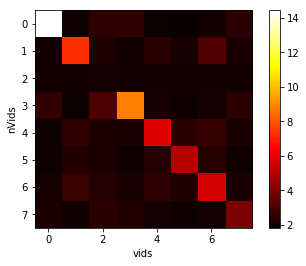

time elapsed: 17.76297092437744
tf2:
diagonal mean = 7.307166467064649 	 sd = 6.032910489670684 CV = 0.8256155812054676
ndiag mean = 2.0242057344135693 	 sd = 0.7899126207219764 CV = 0.3902333677316754


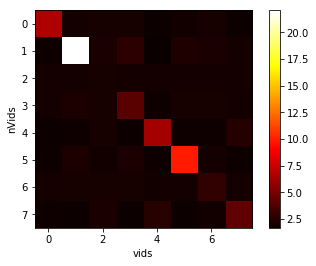

time elapsed: 17.33248496055603
tf3:
diagonal mean = 8.605963959046816 	 sd = 5.802176350604809 CV = 0.674204119168476
ndiag mean = 2.0731396611894772 	 sd = 0.886872936502348 CV = 0.4277921806741659


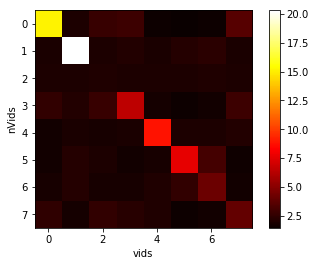

time elapsed: 16.886986255645752
tf4:
diagonal mean = 0.0 	 sd = 0.0 CV = nan
ndiag mean = 0.0 	 sd = 0.0 CV = nan


F:\Softwares\Anaconda\envs\cntk-py35\lib\site-packages\ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in double_scalars
F:\Softwares\Anaconda\envs\cntk-py35\lib\site-packages\ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in double_scalars


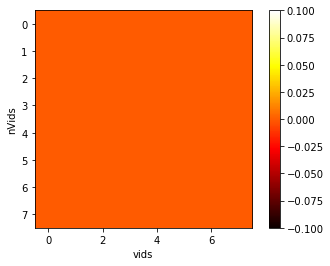

time elapsed: 17.097217321395874
tf5:
diagonal mean = 13.023741587456776 	 sd = 9.030501514071238 CV = 0.6933876454342855
ndiag mean = 2.735206244369798 	 sd = 1.4395149293098404 CV = 0.5262911827117118


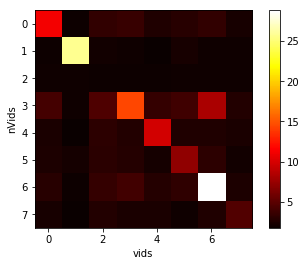

time elapsed: 17.715917825698853
tf6:
diagonal mean = 6.490128893377548 	 sd = 4.374685325524071 CV = 0.6740521486388273
ndiag mean = 2.372375382966326 	 sd = 1.0021368170409424 CV = 0.42241916023757986


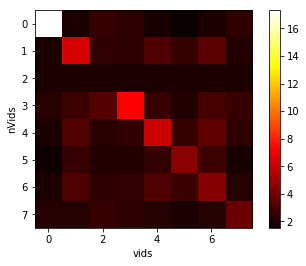

time elapsed: 17.877098321914673
tf7:
diagonal mean = 7.391856172433036 	 sd = 4.8493110263120265 CV = 0.6560342778850189
ndiag mean = 2.367583286607197 	 sd = 1.0293226069911896 CV = 0.43475666212622804


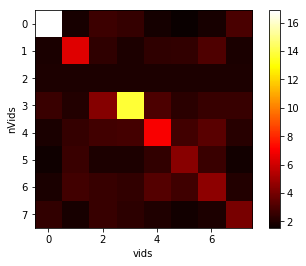

time elapsed: 17.678871870040894
tf8:
diagonal mean = 6.650713173662521 	 sd = 3.528549776360182 CV = 0.5305520903131993
ndiag mean = 2.198940924538316 	 sd = 0.8785150946380889 CV = 0.3995173698550086


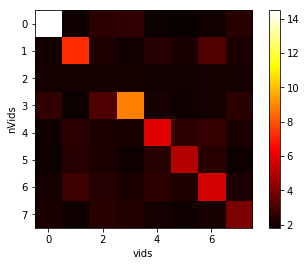

time elapsed: 17.6098153591156


In [24]:
for i in range(1,tfCount+1,1):
    t = time()
    getChange = lambda frame,plane:getChangeTf(frame,plane,tf(i))
    print("tf%i:"%i)
    getMatchness(getMatchScoreExtended,vids,nVids,1)
    print("time elapsed: "+str(time()-t))

Check algo 2 for `vids` and `nVids2` for different `tf`s.

tf1:
diagonal mean = 3.2860112555921077 	 sd = 1.084153347794319 CV = 0.32992989477723655
ndiag mean = 2.0798664476157938 	 sd = 0.8030414963410318 CV = 0.3861024332892045


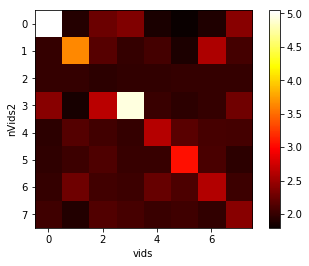

time elapsed: 20.664233446121216
tf2:
diagonal mean = 3.1248761527772766 	 sd = 1.1634865535250423 CV = 0.372330452997626
ndiag mean = 2.015106044157029 	 sd = 0.771726348750245 CV = 0.38297058906052667


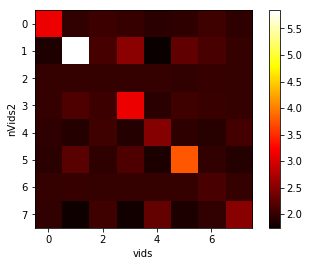

time elapsed: 20.402936935424805
tf3:
diagonal mean = 3.7159774746986507 	 sd = 1.639835593209095 CV = 0.44129320061125465
ndiag mean = 2.0476773230673087 	 sd = 0.8349199339801081 CV = 0.4077399913427003


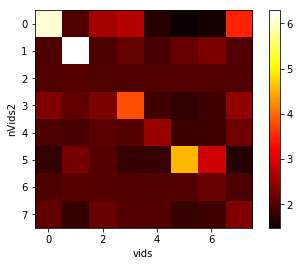

time elapsed: 19.737188577651978
tf4:


F:\Softwares\Anaconda\envs\cntk-py35\lib\site-packages\ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in double_scalars
F:\Softwares\Anaconda\envs\cntk-py35\lib\site-packages\ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in double_scalars


diagonal mean = 0.0 	 sd = 0.0 CV = nan
ndiag mean = 0.0 	 sd = 0.0 CV = nan


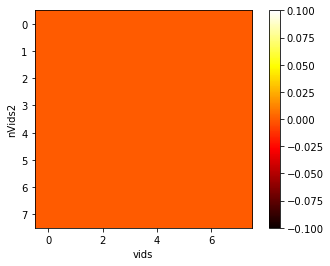

time elapsed: 20.274792432785034
tf5:
diagonal mean = 3.9415256167078123 	 sd = 1.8035593015832028 CV = 0.4575789876737218
ndiag mean = 2.319629381998763 	 sd = 1.0241989559689353 CV = 0.44153560216003573


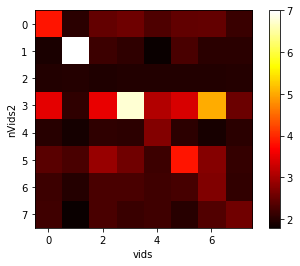

time elapsed: 20.534101963043213
tf6:
diagonal mean = 3.210216152005487 	 sd = 1.1873613369956948 CV = 0.3698695915706256
ndiag mean = 2.139933384932452 	 sd = 0.8385635311238648 CV = 0.39186431551014583


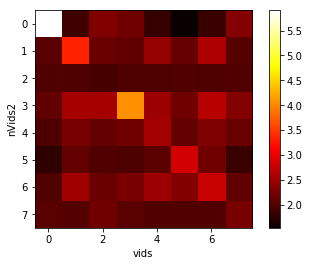

time elapsed: 19.60201907157898
tf7:
diagonal mean = 3.5368027623561074 	 sd = 1.5924554219136675 CV = 0.4502528212381353
ndiag mean = 2.143154660818262 	 sd = 0.8626877304380639 CV = 0.40253171934343157


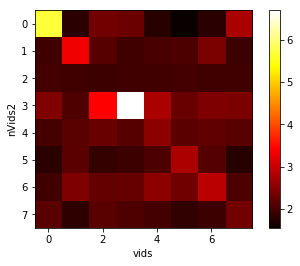

time elapsed: 20.64020323753357
tf8:
diagonal mean = 3.2881360170210088 	 sd = 1.09024488641697 CV = 0.33156927839156486
ndiag mean = 2.075723494423038 	 sd = 0.801284213476721 CV = 0.386026470110097


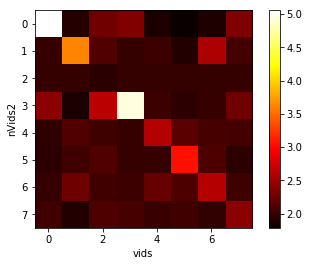

time elapsed: 20.554107427597046


In [25]:
for i in range(1,tfCount+1,1):
    t = time()
    getChange = lambda frame,plane:getChangeTf(frame,plane,tf(i))
    print("tf%i:"%i)
    getMatchness(getMatchScoreExtended,vids,nVids2,1)
    print("time elapsed: "+str(time()-t))

In this situation also, `tf1` seems to perform better.

1:
diagonal mean = 3.2860112555921077 	 sd = 1.084153347794319 CV = 0.32992989477723655
ndiag mean = 2.0798664476157938 	 sd = 0.8030414963410318 CV = 0.3861024332892045


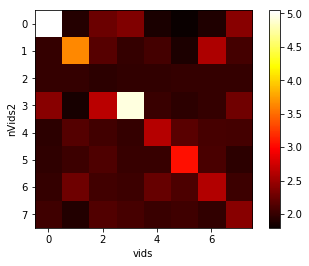

time elapsed: 20.231743812561035
2:
diagonal mean = 6.616562410534287 	 sd = 2.2109288635164073 CV = 0.33415068525558955
ndiag mean = 4.159412110053146 	 sd = 1.6065345770706934 CV = 0.3862407798418816


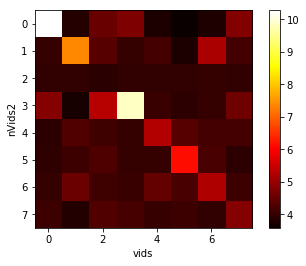

time elapsed: 21.878595113754272
3:
diagonal mean = 10.030078190316786 	 sd = 3.4895755245978264 CV = 0.3479110988353734
ndiag mean = 6.243000407250684 	 sd = 2.416351945061733 CV = 0.3870497817452258


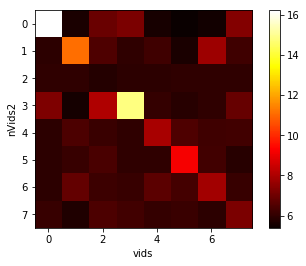

time elapsed: 23.257145166397095
4:
diagonal mean = 13.179824513555774 	 sd = 4.3122935526081525 CV = 0.3271889961943615
ndiag mean = 8.319525261734636 	 sd = 3.210787608047047 CV = 0.3859339934713525


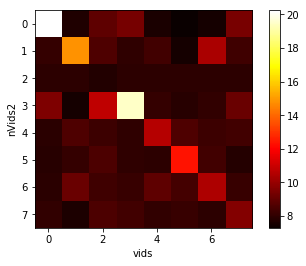

time elapsed: 24.69175887107849
5:
diagonal mean = 16.300045931811418 	 sd = 5.137607945452471 CV = 0.3151897833260603
ndiag mean = 10.397676877784386 	 sd = 4.007545464953023 CV = 0.38542700567234595


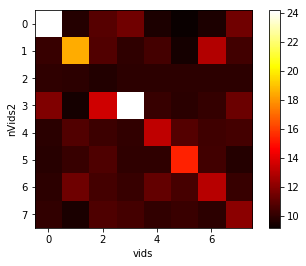

time elapsed: 25.651840448379517
6:
diagonal mean = 19.38531019320532 	 sd = 5.885680489299904 CV = 0.30361549186676795
ndiag mean = 12.464425278837506 	 sd = 4.793588732378406 CV = 0.3845816092713967


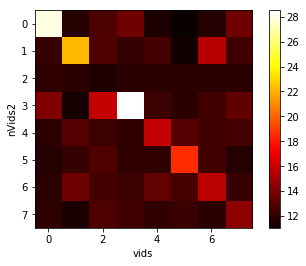

time elapsed: 26.70602297782898
7:
diagonal mean = 22.43930717725959 	 sd = 6.622648104090744 CV = 0.2951360330234375
ndiag mean = 14.526082876069838 	 sd = 5.579690973766335 CV = 0.3841153201017652


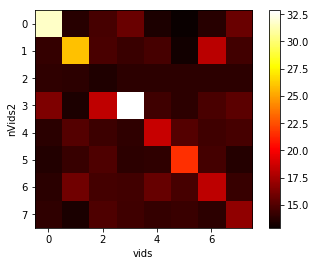

time elapsed: 27.690128803253174
8:
diagonal mean = 25.464140143397948 	 sd = 7.320404732154452 CV = 0.2874789681069362
ndiag mean = 16.569811152515964 	 sd = 6.3536611581824936 CV = 0.38344801275648527


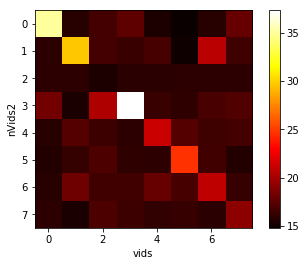

time elapsed: 29.2869234085083
9:
diagonal mean = 28.436100924328116 	 sd = 7.990434610136097 CV = 0.28099614048352145
ndiag mean = 18.61264095340391 	 sd = 7.12852315813812 CV = 0.3829936426530832


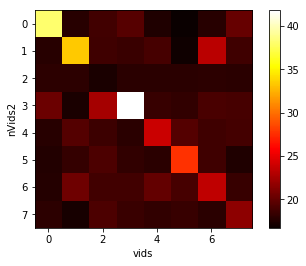

time elapsed: 30.640446662902832
10:
diagonal mean = 31.436418708996875 	 sd = 8.681969579135458 CV = 0.2761755293916715
ndiag mean = 20.64435638064678 	 sd = 7.899331563361632 CV = 0.3826387908497319


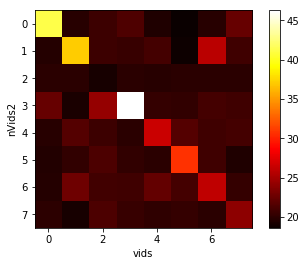

time elapsed: 31.805756092071533
11:
diagonal mean = 34.42145599346408 	 sd = 9.380484535970748 CV = 0.27251852849431785
ndiag mean = 22.676590059792375 	 sd = 8.671153946498933 CV = 0.3823835031473125


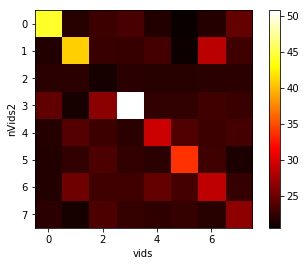

time elapsed: 32.736801862716675
12:
diagonal mean = 37.41864490327816 	 sd = 10.092321159621585 CV = 0.2697136998335667
ndiag mean = 24.70110698369365 	 sd = 9.441386549152615 CV = 0.382225240163743


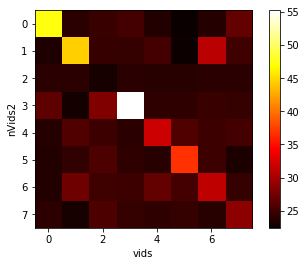

time elapsed: 34.482765913009644
13:
diagonal mean = 40.394027860925405 	 sd = 10.805522195190719 CV = 0.2675029643588301
ndiag mean = 26.72680832131587 	 sd = 10.212416455556475 CV = 0.3821038536581115


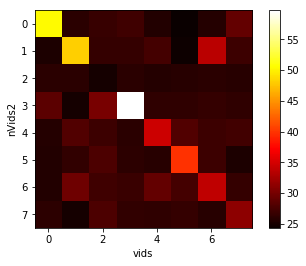

time elapsed: 36.023500204086304
14:
diagonal mean = 43.4305185825934 	 sd = 11.610676440116466 CV = 0.2673391158808297
ndiag mean = 28.74227021976293 	 sd = 10.98049042575489 CV = 0.38203281584225046


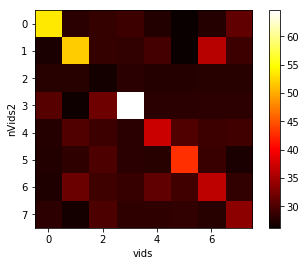

time elapsed: 38.19495368003845
15:
diagonal mean = 46.46054454701979 	 sd = 12.420636535591184 CV = 0.2673372999970123
ndiag mean = 30.757939556178624 	 sd = 11.749360650435259 CV = 0.3819943994940018


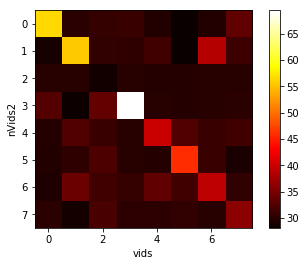

time elapsed: 39.097936391830444
16:
diagonal mean = 49.63451402017921 	 sd = 13.275842990334642 CV = 0.2674720051643352
ndiag mean = 32.7711039155549 	 sd = 12.516077967925158 CV = 0.38192420982145686


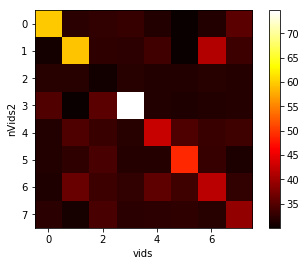

time elapsed: 40.42845058441162
17:
diagonal mean = 52.82158595070661 	 sd = 14.148451338598896 CV = 0.26785358833796297
ndiag mean = 34.78430134142695 	 sd = 13.283411561449215 CV = 0.38187949877346283


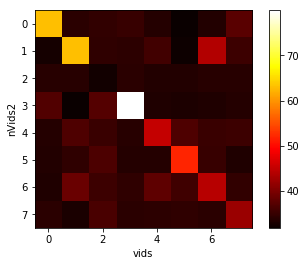

time elapsed: 41.85805559158325
18:
diagonal mean = 56.08018999855851 	 sd = 15.103404031584422 CV = 0.2693179896853531
ndiag mean = 36.8026259911475 	 sd = 14.052328758804947 CV = 0.381829512985978


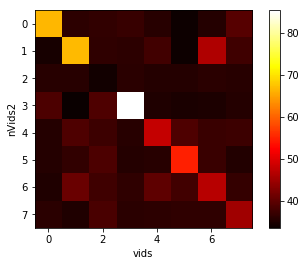

time elapsed: 43.60602307319641
19:
diagonal mean = 59.31743093081585 	 sd = 16.05006121458124 CV = 0.27057916977727897
ndiag mean = 38.817005032412894 	 sd = 14.820324844032474 CV = 0.38179980221702414


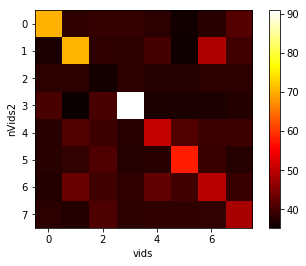

time elapsed: 45.1727831363678
20:
diagonal mean = 62.587601124573936 	 sd = 17.016024590201337 CV = 0.27187532809146586
ndiag mean = 40.83057751150638 	 sd = 15.589092328428729 CV = 0.3817994571356626


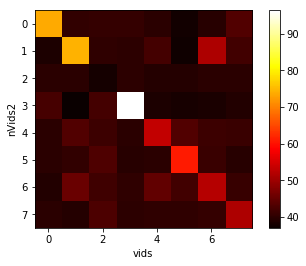

time elapsed: 46.630420207977295
21:
diagonal mean = 65.83487463249979 	 sd = 17.976196438185646 CV = 0.27304975574923607
ndiag mean = 42.84505833969153 	 sd = 16.35843444785228 CV = 0.3818044619791747


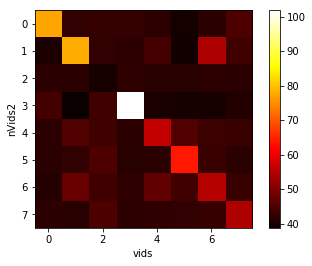

time elapsed: 47.80574369430542
22:
diagonal mean = 69.11617761064682 	 sd = 18.967014397177294 CV = 0.27442221275638906
ndiag mean = 44.85921005891038 	 sd = 17.12838464505737 CV = 0.38182537370952124


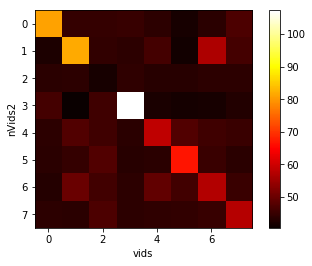

time elapsed: 51.56196594238281
23:
diagonal mean = 72.40249504967498 	 sd = 19.950033016690565 CV = 0.27554344643790174
ndiag mean = 46.871073423349536 	 sd = 17.897922580111917 CV = 0.38185433515580197


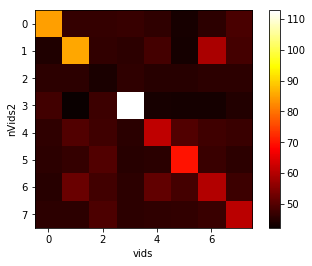

time elapsed: 54.697492599487305
24:
diagonal mean = 75.7155419533956 	 sd = 20.94351425034668 CV = 0.2766078629304116
ndiag mean = 48.8817029670416 	 sd = 18.66798159620087 CV = 0.38190121176399533


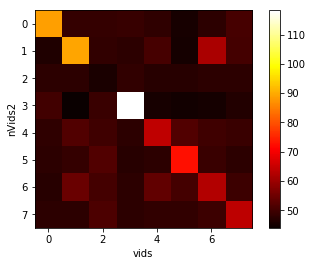

time elapsed: 55.4833722114563


In [26]:
for i in range(1,25,1):
    t = time()
    getChange = lambda frame,plane:getChangeTf(frame,plane,tf(1))
    print("%i:"%i)
    getMatchness(getMatchScoreExtended,vids,nVids2,i)
    print("time elapsed: "+str(time()-t))

Getting number of frames higher doesn't seem work better especially for `vid[2]` which is a dark one.

Let's redefine `getchangeTF` so that it will make use of average of frames.

In [15]:
def getChangeTfAvg(frame,plane,tf):
    """
        this gives 3 outputs regarding the specified plane of rFrame and frame
        inc: 
        dec:
        incdec:
    """
    frame = np.int32(np.sum(frame[:,:,plane],axis=0))
   
    # this is the transformation done:
    rFrame = tf(frame)
    
    inc = (rFrame>frame)
    dec =  (rFrame<frame)
    incdec = np.logical_or(inc, dec)
    
    return np.array([inc,dec,incdec])

For this method, we need to define new transformation for a vector.

In [16]:
tf_ = lambda vector : vector[::-1]

diagonal mean = 521.374393095624 	 sd = 392.1637905230116 CV = 0.7521730942606646
ndiag mean = 46.479330427044275 	 sd = 44.91914092319939 CV = 0.966432616616674


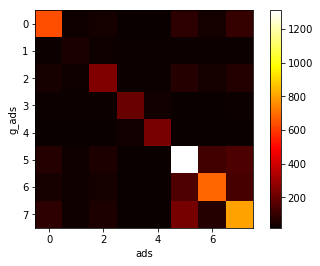

time elapsed: 14.321100234985352


In [29]:
t = time()
getChange = lambda frame,plane:getChangeTfAvg(frame,plane,tf_)
getMatchness(getMatchScoreExtended,ads,g_ads,10)
print("time elapsed: "+str(time()-t))

This `getChangeTfAvg` is not that useful. It doesn't even give required recognition for `ads` and `g_ads` even when considering 10 frames. May be the noise is unncessarily prominent which may not happen in practical situations.

Let's generate new `nVids` list with $\sigma=1$ AWGN.

In [17]:
nVids3 = ["nVids3_%i.mp4"%i for i in range(1,9,1)]

In [31]:
addNoiseArray(vids,nVids3,0,1,130)

Check with original algo for **10** to **1** frames to compare `vids` and `nVids` using pixelwise method.

Doing 10 iterations in getMatchScoreExtended function
diagonal mean = 329.53394360491313 	 sd = 189.0103615752877 CV = 0.57356871801315
ndiag mean = 24.171777651240728 	 sd = 10.83207537131342 CV = 0.4481290340992945


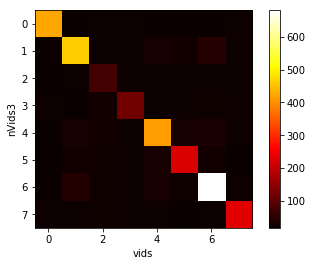

time elapsed: 26.002232551574707
Doing 9 iterations in getMatchScoreExtended function
diagonal mean = 295.36895295061674 	 sd = 171.1706089329242 CV = 0.5795145604268791
ndiag mean = 21.819553634664764 	 sd = 9.772250044736003 CV = 0.44786663413731853


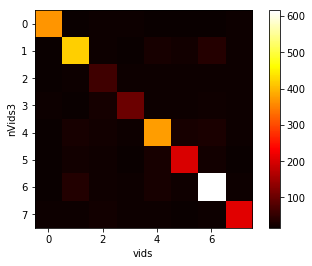

time elapsed: 23.017876148223877
Doing 8 iterations in getMatchScoreExtended function
diagonal mean = 260.5192447057267 	 sd = 152.96705662766578 CV = 0.5871622144477348
ndiag mean = 19.44381568011533 	 sd = 8.709426948630526 CV = 0.4479278703272951


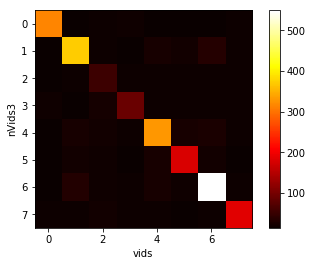

time elapsed: 24.79887890815735
Doing 7 iterations in getMatchScoreExtended function
diagonal mean = 226.02710973858373 	 sd = 134.41605365222895 CV = 0.5946899635521181
ndiag mean = 17.077677839706602 	 sd = 7.652056450743009 CV = 0.4480735918879749


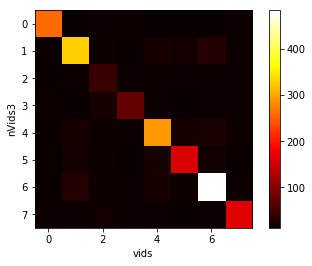

time elapsed: 24.030014514923096
Doing 6 iterations in getMatchScoreExtended function
diagonal mean = 195.42605473865137 	 sd = 116.91299213485122 CV = 0.598246698942995
ndiag mean = 14.657453792766846 	 sd = 6.5777398969587955 CV = 0.44876415712835305


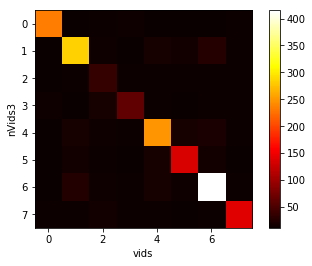

time elapsed: 21.219855546951294
Doing 5 iterations in getMatchScoreExtended function
diagonal mean = 161.8914372059136 	 sd = 97.93837491581823 CV = 0.6049632803694741
ndiag mean = 12.236551138221452 	 sd = 5.511310034364933 CV = 0.450397335990375


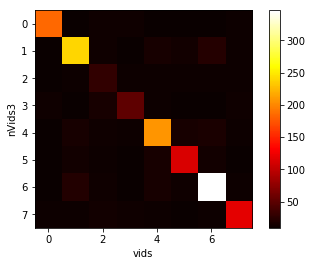

time elapsed: 20.129629611968994
Doing 4 iterations in getMatchScoreExtended function
diagonal mean = 127.24578890292045 	 sd = 78.00234658196786 CV = 0.6130053281486442
ndiag mean = 9.801933113257421 	 sd = 4.4159102991150005 CV = 0.45051422490756887


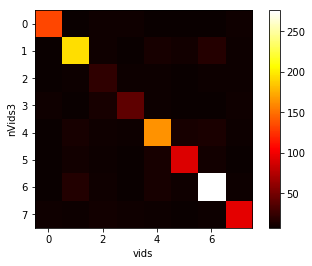

time elapsed: 20.273791790008545
Doing 3 iterations in getMatchScoreExtended function
diagonal mean = 97.18827269570451 	 sd = 59.165259442215266 CV = 0.6087695336191548
ndiag mean = 7.355883825224768 	 sd = 3.3242932348301335 CV = 0.4519230202399989


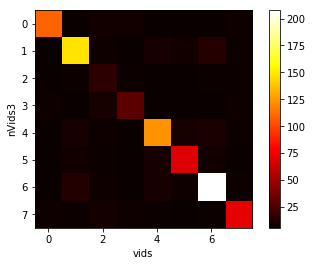

time elapsed: 18.364487409591675
Doing 2 iterations in getMatchScoreExtended function
diagonal mean = 64.47573324063285 	 sd = 40.00940574507847 CV = 0.6205343271670525
ndiag mean = 4.892963262225289 	 sd = 2.211992353295846 CV = 0.45207622349689286


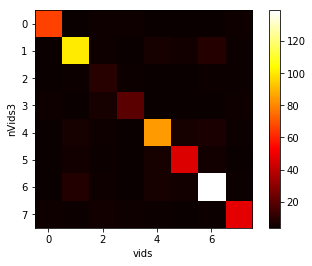

time elapsed: 16.193203687667847


In [32]:
for i in range(10,1,-1):
    print("Doing {0} iterations in getMatchScoreExtended function".format(i))
    t = time()
    getChange = lambda frame,plane:getChangeTf(frame,plane,tf1)
    getMatchness(getMatchScoreExtended,vids,nVids3,i)
    print("time elapsed: "+str(time()-t)+"\n==============================")

Number of iterations doesn't seem matter here. It may be because that we are doing pixel by pixel matching and also because the adjacent frames are highly related not independent from each other and very much alike.(for 10 frames it will take 400 ms which is very small time to occur big difference in frames.) So it can be said that algo 2 is immune to $\sigma = 1$ AWGN. 

Another approach of averaging is dividing the $n\times m$ frame to $a\times b$ blocks. Here $a|n\wedge b|m$.
So there will be $\frac{mn}{ab}$ blocks. The values $a$ ,$b$ should be higher enough to cancel out the noise  and lower enough to cater for more information content from the video. (If $a$ and $b$ are more than enough there will be less number of blocks to get information.)

Let's define a function, that gets $n\times m$ resolution frame $A$ and outputs a $\frac{n}{a}\times \frac{m}{b}$ resolution frame $B$ s.t. $$b_{i,j}=\frac{1}{ab}\sum_{k=0}^{a-1}\sum_{l=0}^{b-1}a_{i+k,j+l}$$
which is actually a downsampled version of $A$ (**Box** filtering).

This downsampling process takes time if implemented using for loops. But for the time being, before using **CUDA** or other optimizations, let's implement it using skimage.

In [18]:
def getChangeTfAvg2(frame,plane,tf,factors):
    """
        this gives 3 outputs regarding the specified plane of rFrame and frame
        inc: 
        dec:
        incdec:
    """
    frame = transform.downscale_local_mean(frame[:,:,0],factors)
   
    # this is the transformation done:
    rFrame = tf(frame)
    
    inc = (rFrame>frame)
    dec =  (rFrame<frame)
    incdec = np.logical_or(inc, dec)
    
    return np.array([inc,dec,incdec])

Downscaled by fractor (2, 2)
diagonal mean = 9.28535004933977 	 sd = 10.221390310534385 CV = 1.1008082900720766
ndiag mean = 2.256617176264961 	 sd = 0.9693304336220309 CV = 0.42955023289613425


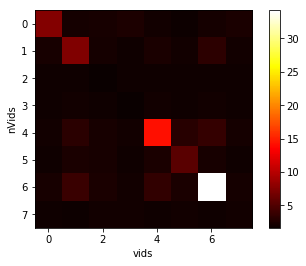

time elapsed: 19.58902144432068

Downscaled by fractor (6, 6)
diagonal mean = 8.963028498085205 	 sd = 7.958511106297277 CV = 0.8879265649994837
ndiag mean = 2.2832549628776646 	 sd = 1.0090586376259325 CV = 0.44193865951535316


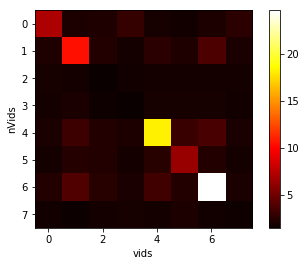

time elapsed: 18.81515145301819

Downscaled by fractor (12, 12)
diagonal mean = 9.003185421708668 	 sd = 7.823194579252654 CV = 0.8689362945240697
ndiag mean = 2.2763144437857887 	 sd = 1.0184769872641524 CV = 0.44742368087350043


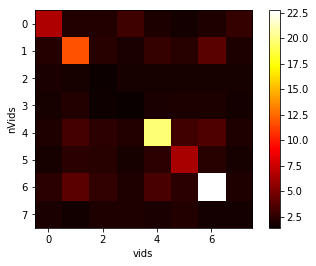

time elapsed: 18.568876028060913

Downscaled by fractor (144, 144)
diagonal mean = 7.6306089743589745 	 sd = 7.787098868804067 CV = 1.0205081789632968
ndiag mean = 2.5190884016776875 	 sd = 1.5042919790644103 CV = 0.5971572804124567


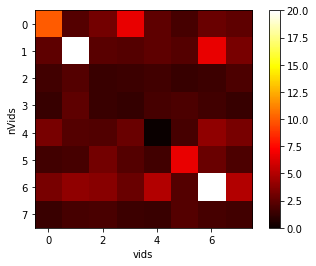

time elapsed: 20.626729011535645

Downscaled by fractor (1, 1)
diagonal mean = 5.184968044978732 	 sd = 2.562744749107851 CV = 0.49426432851205027
ndiag mean = 2.1921133627296965 	 sd = 0.8679378701365931 CV = 0.39593658106066487


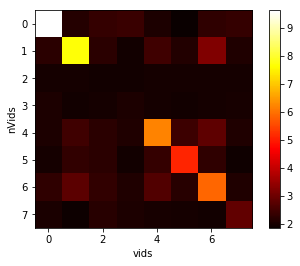

time elapsed: 21.410069704055786



In [34]:
factorsList = [(2,2),(6,6),(12,12),(144,144),(1,1)]
for factors in factorsList:
    print("Downscaled by fractor {0}".format(factors))
    t = time()
    getChange = lambda frame,plane:getChangeTfAvg2(frame,plane,tf1,factors)
    getMatchness(getMatchScoreExtended,vids,nVids,1)
    print("time elapsed: "+str(time()-t)+"\n")

Out of the factors, (1,1) seems to work better than any other, which is unexpected. The downscaling algorithm used by skimage uses **Box** filter to get the mean (just averaging). Let's check applying **Gaussian** filter after averaging. 

In [19]:
def getChangeTfAvg3(frame,plane,tf,factors):
    """
        this gives 3 outputs regarding the specified plane of rFrame and frame
        inc: 
        dec:
        incdec:
    """
    frame = filters.gaussian(transform.downscale_local_mean(frame[:,:,0],factors))
   
    # this is the transformation done:
    rFrame = tf(frame)
    
    inc = (rFrame>frame)
    dec =  (rFrame<frame)
    incdec = np.logical_or(inc, dec)
    
    return np.array([inc,dec,incdec])

Downscaled by fractor (2, 2)
diagonal mean = 7.874668780372398 	 sd = 6.107385625556716 CV = 0.7755736521616461
ndiag mean = 2.2665402084780735 	 sd = 0.9954523410464043 CV = 0.4391946532970736


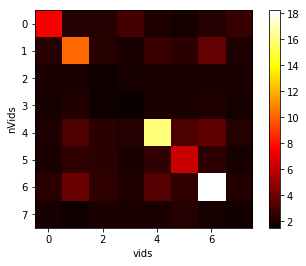

time elapsed: 22.648460865020752

Downscaled by fractor (6, 6)
diagonal mean = 7.772370805359252 	 sd = 5.953429937356313 CV = 0.7659734830524644
ndiag mean = 2.26574721651593 	 sd = 1.0168192258157884 CV = 0.4487787597856415


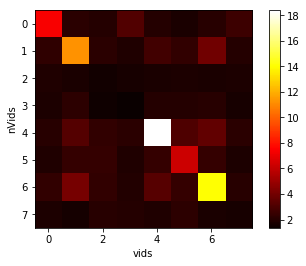

time elapsed: 19.53296160697937

Downscaled by fractor (12, 12)
diagonal mean = 8.818241571716143 	 sd = 7.8767889691377135 CV = 0.89323805716572
ndiag mean = 2.270729779701757 	 sd = 1.0527936037515981 CV = 0.46363667450112644


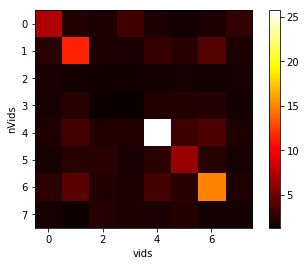

time elapsed: 19.95443367958069

Downscaled by fractor (72, 72)
diagonal mean = 10.461650652024709 	 sd = 8.90958952151089 CV = 0.8516428064615751
ndiag mean = 3.2426329225636144 	 sd = 4.89308302818775 CV = 1.5089845644074


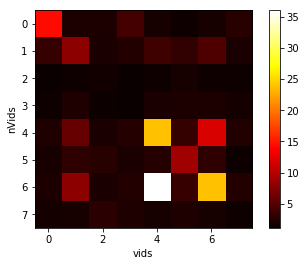

time elapsed: 20.06856107711792

Downscaled by fractor (144, 144)
diagonal mean = 10.126488095238095 	 sd = 8.14293750286684 CV = 0.804122557226527
ndiag mean = 2.4708168815311673 	 sd = 1.650660795346993 CV = 0.6680627802429766


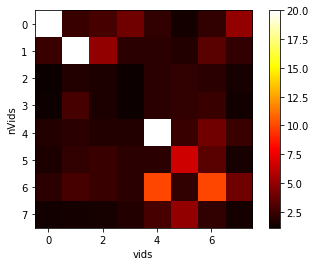

time elapsed: 18.987346410751343

Downscaled by fractor (1, 1)
diagonal mean = 7.953298043793158 	 sd = 6.665164189226912 CV = 0.8380377740814681
ndiag mean = 2.2609116542601355 	 sd = 0.9810851206731481 CV = 0.4339334174444777


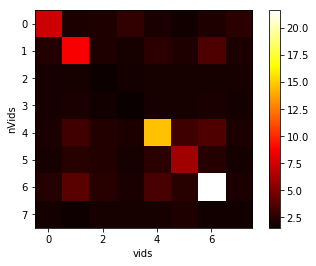

time elapsed: 24.91487765312195



In [36]:
factorsList = [(2,2),(6,6),(12,12),(72,72),(144,144),(1,1)]
for factors in factorsList:
    print("Downscaled by fractor {0}".format(factors))
    t = time()
    getChange = lambda frame,plane:getChangeTfAvg3(frame,plane,tf1,factors)
    getMatchness(getMatchScoreExtended,vids,nVids,1)
    print("time elapsed: "+str(time()-t)+"\n")

Applying Gaussian filter have made some difference.(see `(144,144)` for both the cases.)

But no signifcant difference can be seen among different `factors`. Out of them, 

Since the resolution of the video is, 576 x 720, when applied, (144,144) factors, the frame is divided in to $\frac{576}{144}\times \frac{720}{144} = 20$ blocks. 

Let's use the factors `(144,144)` and do the process using more than 1 iterations.

Using 1 frames.
diagonal mean = 10.126488095238095 	 sd = 8.14293750286684 CV = 0.804122557226527
ndiag mean = 2.4708168815311673 	 sd = 1.650660795346993 CV = 0.6680627802429766


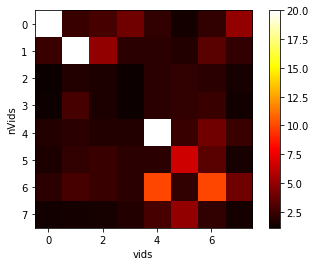

time elapsed: 16.602914810180664

Using 2 frames.
diagonal mean = 19.021915584415584 	 sd = 16.619525534898667 CV = 0.8737040946872268
ndiag mean = 4.852366696586621 	 sd = 2.8813278693568907 CV = 0.5937984594988976


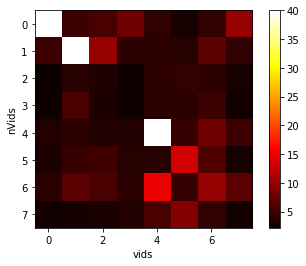

time elapsed: 17.185664653778076

Using 3 frames.
diagonal mean = 26.667343073593074 	 sd = 22.28052536548435 CV = 0.8354985085689807
ndiag mean = 7.220053718948013 	 sd = 4.2601157014818725 CV = 0.5900393358988174


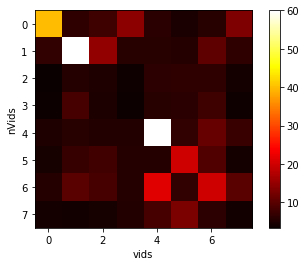

time elapsed: 18.5080463886261

Using 4 frames.
diagonal mean = 34.68429834054834 	 sd = 28.90988146980263 CV = 0.8335149578622147
ndiag mean = 9.672713162678887 	 sd = 5.494980371038067 CV = 0.5680909046532933


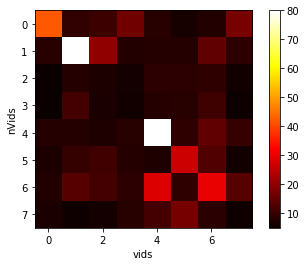

time elapsed: 19.65859293937683

Using 5 frames.
diagonal mean = 42.8885107947608 	 sd = 35.91358191685356 CV = 0.8373706909226775
ndiag mean = 12.042240110987347 	 sd = 6.73815208846416 CV = 0.5595430772316411


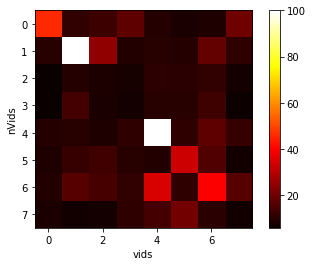

time elapsed: 21.380770921707153

Using 6 frames.
diagonal mean = 52.46589174714174 	 sd = 42.874221413195556 CV = 0.8171827445500586
ndiag mean = 14.50149216845369 	 sd = 7.92165397599149 CV = 0.5462647487562782


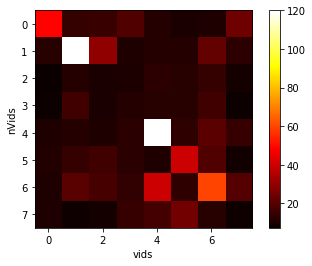

time elapsed: 21.96299171447754

Using 7 frames.
diagonal mean = 62.02724705849705 	 sd = 50.230692355945436 CV = 0.8098165683312295
ndiag mean = 16.942923257206207 	 sd = 9.131372315590502 CV = 0.5389490453901882


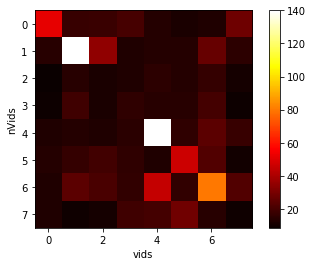

time elapsed: 22.928775310516357

Using 8 frames.
diagonal mean = 68.7969357031857 	 sd = 55.576617559521004 CV = 0.8078356541823052
ndiag mean = 19.467573210427588 	 sd = 10.473218118510843 CV = 0.5379827267273859


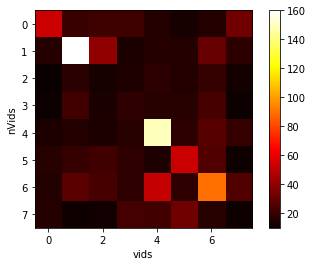

time elapsed: 24.333510875701904

Using 9 frames.
diagonal mean = 76.83556374181374 	 sd = 62.840246589379404 CV = 0.8178536543382173
ndiag mean = 21.91153351599504 	 sd = 11.791792524081032 CV = 0.5381545986032072


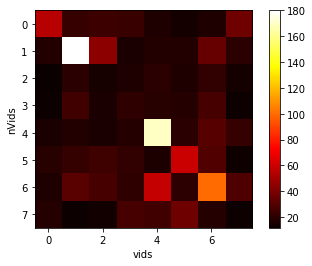

time elapsed: 24.88598656654358



In [22]:
factors = (144,144)
for i in range(1,10,1):
    print("Using {0} frames.".format(i))
    t = time()
    getChange = lambda frame,plane:getChangeTfAvg3(frame,plane,tf1,factors)
    getMatchness(getMatchScoreExtended,vids,nVids,i)
    print("time elapsed: "+str(time()-t)+"\n")

Although the graphical results doesn't show any visible improvement, the CV value, of both diagonal and non diagonal is decreasing, meaning the the ability to identify ads is getting better. Just now I changed `getMatchnessExtended` to give out stats so that we can visualise how the stats change in relation to factors like **number of frames considered**, **method of transformation**, **downscaling factor**, **downscaling method** (box, gaussian, etc),**noise level** etc. Some of these factors are categorical while the rest are continuous. For both the cases we have to implement 2 different visualisation methods.

It's better to define new function to do this without extending `getMatchnessExtended`  more. Since we are now more interested in aggregate effect of mentioned factors, we don't need to plot individual results on a heat map.

In [20]:
def getStats(matchFunc,list1,list2,n):
    """This function says how good the matchFunc is over video lists list1 and list2
        using n frames.
    ."""
    l = []
    for i in range(len(list2)):
        m = []
        for j in range(len(list1)):
            score = matchFunc(list1[j],list2[i],n)
            m.append(score)
        l.append(m)
    l = np.array(l)
    diag = l.diagonal()
    mean_diag,std_dev_diag = stats(diag)
    cv_diag = std_dev_diag/mean_diag
    eye = ~np.eye(l.shape[0],dtype=bool)
    ndiag = eye*l
    mean_ndiag = np.sum(ndiag)/np.sum(eye)
    mean_ndiag_MAT = eye*mean_ndiag
    std_dev_ndiag = np.sqrt(np.sum((ndiag-mean_ndiag)**2)/np.sum(eye))
    cv_ndiag = std_dev_ndiag/mean_ndiag
    return mean_diag, std_dev_diag, cv_diag,mean_ndiag,std_dev_ndiag,cv_ndiag

Actually in a downsampling process what happens is, filtering with Gaussian kernel before averaging. What's done before is just a mistake. So let's do the right thing.

In [21]:
def getChangeTfAvg5(frame,plane,tf,factors,sigma):
    """
        this gives 3 outputs regarding the specified plane of rFrame and frame
        inc: 
        dec:
        incdec:
    """
    
    # only this line changes from getChangeAvg3
    frame = transform.downscale_local_mean(filters.gaussian(frame[:,:,0],sigma=sigma),factors)
   
    # this is the transformation done:
    rFrame = tf(frame)
    
    inc = (rFrame>frame)
    dec =  (rFrame<frame)
    incdec = np.logical_or(inc, dec)
    
    return np.array([inc,dec,incdec])

Downscaled by fractor (2, 2)
diagonal mean = 8.073260388311876 	 sd = 6.7402478729229225 CV = 0.8348854798095162
ndiag mean = 2.2627462118095956 	 sd = 0.9842383675410084 CV = 0.434975147634378


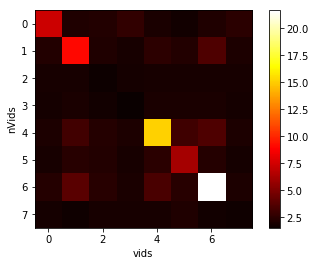

time elapsed: 20.26730966567993

Downscaled by fractor (6, 6)
diagonal mean = 8.487614516406364 	 sd = 7.069460281772102 CV = 0.8329148629579015
ndiag mean = 2.267650151883941 	 sd = 0.9983498099062772 CV = 0.4402574220176151


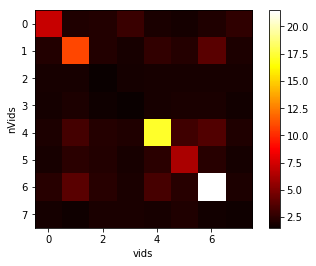

time elapsed: 18.812480449676514

Downscaled by fractor (12, 12)
diagonal mean = 8.293315192708418 	 sd = 6.810496169750969 CV = 0.8212031029206317
ndiag mean = 2.264604804944728 	 sd = 1.0080797238507933 CV = 0.44514597939987915


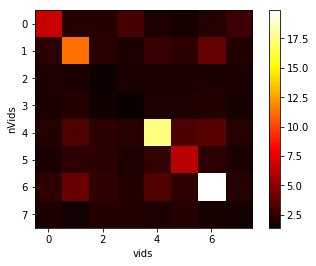

time elapsed: 19.33798384666443

Downscaled by fractor (72, 72)
diagonal mean = 11.688955342902712 	 sd = 11.694439803885626 CV = 1.0004692002682893
ndiag mean = 2.296671739487059 	 sd = 1.0990123206229516 CV = 0.4785239012295271


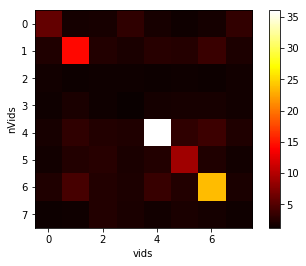

time elapsed: 19.578102111816406

Downscaled by fractor (144, 144)
diagonal mean = 7.6306089743589745 	 sd = 7.787098868804067 CV = 1.0205081789632968
ndiag mean = 2.5190884016776875 	 sd = 1.5042919790644103 CV = 0.5971572804124567


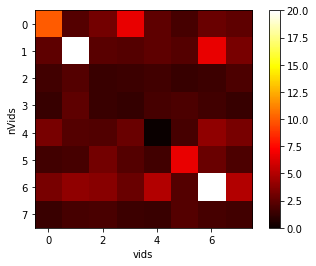

time elapsed: 19.88232731819153

Downscaled by fractor (1, 1)
diagonal mean = 7.955464562712759 	 sd = 6.668505357171379 CV = 0.8382295345047033
ndiag mean = 2.260919929770641 	 sd = 0.9810955840612305 CV = 0.43393645707778683


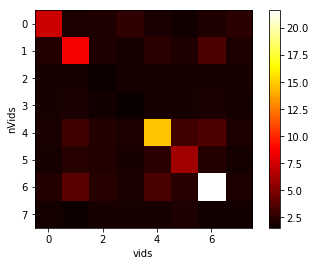

time elapsed: 20.751567602157593



In [49]:
factorsList = [(2,2),(6,6),(12,12),(72,72),(144,144),(1,1)]
for factors in factorsList:
    print("Downscaled by fractor {0}".format(factors))
    t = time()
    getChange = lambda frame,plane:getChangeTfAvg4(frame,plane,tf1,factors)
    getMatchness(getMatchScoreExtended,vids,nVids,1)
    print("time elapsed: "+str(time()-t)+"\n")

This performs poorly than the "mistaken" method! That may be because of using the default value for $\sigma$ for all cases which is $1$. So it would be meaningless to use the same value for sigma for different scaling factors. 

Let's test for (144,144) with higher $\sigma$ values.

Assume for now lower the CV, higher the seperation. Figure out a optimum $\sigma$.

sigma = 1.0
sigma = 1.1
sigma = 1.2000000000000002
sigma = 1.3000000000000003
sigma = 1.4000000000000004
sigma = 1.5000000000000004
sigma = 1.6000000000000005
sigma = 1.7000000000000006
sigma = 1.8000000000000007
sigma = 1.9000000000000008
sigma = 2.000000000000001
sigma = 2.100000000000001
sigma = 2.200000000000001
sigma = 2.300000000000001
sigma = 2.4000000000000012
sigma = 2.5000000000000013
sigma = 2.6000000000000014
sigma = 2.7000000000000015
sigma = 2.8000000000000016
sigma = 2.9000000000000017
sigma = 3.0000000000000018
sigma = 3.100000000000002
sigma = 3.200000000000002
sigma = 3.300000000000002
sigma = 3.400000000000002
sigma = 3.500000000000002
sigma = 3.6000000000000023
sigma = 3.7000000000000024
sigma = 3.8000000000000025
sigma = 3.9000000000000026
sigma = 4.000000000000003
sigma = 4.100000000000003
sigma = 4.200000000000003
sigma = 4.3000000000000025
sigma = 4.400000000000003
sigma = 4.5000000000000036
sigma = 4.600000000000003
sigma = 4.700000000000003
sigma = 4.800000000

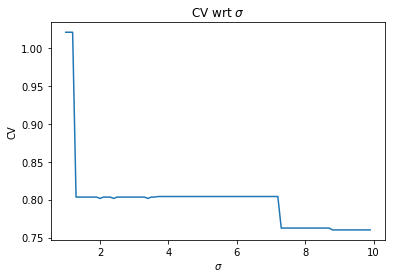

In [22]:
sigmas = np.arange(1,10,.1)
cvs = []
for sigma in sigmas:
    getChange = lambda frame,plane:getChangeTfAvg5(frame,plane,tf1,(144,144),sigma)
    cvs.append(getStats(getMatchScoreExtended,vids,nVids,1)[2])
plt.plot(sigmas,cvs)
plt.title("CV wrt $\sigma$")
plt.ylabel("CV")
plt.xlabel("$\sigma$")
plt.show()

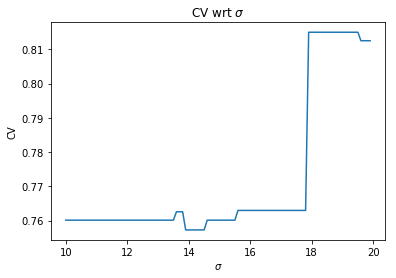

In [26]:
sigmas = np.arange(10,20,.1)
cvs = []
for sigma in sigmas:
    getChange = lambda frame,plane:getChangeTfAvg5(frame,plane,tf1,(144,144),sigma)
    cvs.append(getStats(getMatchScoreExtended,vids,nVids,1)[2])
plt.plot(sigmas,cvs)
plt.title("CV wrt $\sigma$")
plt.ylabel("CV")
plt.xlabel("$\sigma$")
plt.show()

Save the data for later usage

In [27]:
np.save("data/2/sigmas.npy",sigmas)
np.save('data/2/sigmas_cvs.npy',cvs)

The optimum $\sigma$ for `factors` `(144,144)`, is around $10$. Let's look at the heat-map for that sigma value to make sure that CV is a clear representation of `seperation`.

diagonal mean = 10.556891025641026 	 sd = 8.024365681044694 CV = 0.7601068971494329
ndiag mean = 2.5308367228010087 	 sd = 1.5272112074415958 CV = 0.603441223087419


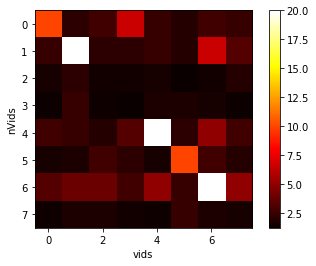

(10.556891025641026,
 8.0243656810446939,
 0.76010689714943291,
 2.5308367228010087,
 1.5272112074415958,
 0.60344122308741899)

In [30]:
getChange = lambda frame,plane:getChangeTfAvg5(frame,plane,tf1,(144,144),10)
getMatchness(getMatchScoreExtended,vids,nVids,1)

It's obvious that $\sigma=10$ is better than $\sigma=1$ for `factors` `(144,144)`. So different downscaling factors demand different $\sigma$ values.

## CV Vs Number of frames

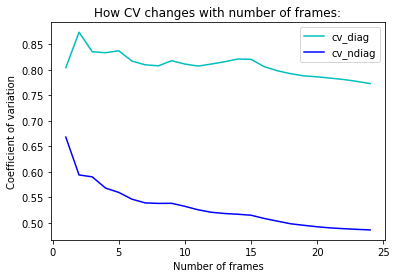

In [38]:
factors = (144,144)
l = []
frameCount = []
for i in range(1,25,1):
    frameCount.append(i)
    getChange = lambda frame,plane:getChangeTfAvg3(frame,plane,tf1,factors)
    s = getStats(getMatchScoreExtended,vids,nVids,i)
    l.append(s)
l = np.array(l).T
plt.plot(frameCount,l[2],'c',label='cv_diag')
plt.plot(frameCount,l[5],'b',label='cv_ndiag')
plt.legend(loc = "best")
plt.title("How CV changes with number of frames:")
plt.xlabel("Number of frames")
plt.ylabel("Coefficient of variation")
plt.show()

## CV Vs Noise

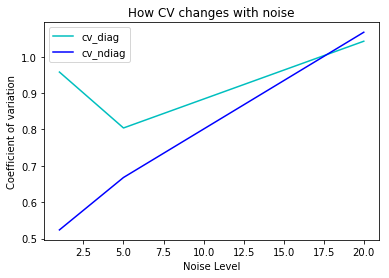

In [23]:
factors = (144,144)
# videos in ascening order of noise standard deviation
vidList = [nVids3,nVids,nVids2]
sigmas = [1,5,20]
l = []
for nvids in vidList:
    getChange = lambda frame,plane:getChangeTfAvg3(frame,plane,tf1,factors)
    s = getStats(getMatchScoreExtended,vids,nvids,1)
    l.append(s)
l = np.array(l).T
plt.plot(sigmas,l[2],'c',label='cv_diag')
plt.plot(sigmas,l[5],'b',label='cv_ndiag')
plt.legend(loc = "best")
plt.title("How CV changes with noise")
plt.xlabel("Noise Level")
plt.ylabel("Coefficient of variation")
plt.show()

When noise level increases, the data become utterly useless.

## CV Vs tf

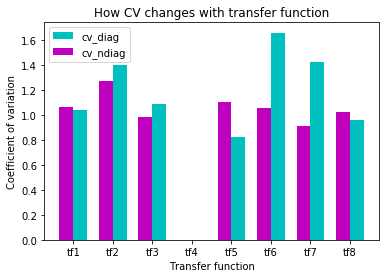

In [31]:
tfs = [tf(i) for i in range(1,1+tfCount,1)]
factors = (144,144)
l = []
ind = np.arange(tfCount)
width = 0.35
for tff in tfs:
    getChange = lambda frame,plane:getChangeTfAvg3(frame,plane,tff,factors)
    s = getStats(getMatchScoreExtended,vids,nvids,1)
    l.append(s)
l = np.array(l).T
fig,ax = plt.subplots()
diag = ax.bar(ind+width,l[2],width,color='c',label='cv_diag')
ndiag = ax.bar(ind,l[5],width,color='m',label='cv_ndiag')
ax.legend(loc = "best")
ax.set_title("How CV changes with transfer function")
ax.set_xlabel("Transfer function")
ax.set_ylabel("Coefficient of variation")
ax.set_xticks(ind+width/2)
ax.set_xticklabels([getName(tff) for tff in tfs ])
plt.show()

`tf1` performs best for the given conditions apart from the more _sophisticated_ `tf8`. `tf4`'s `cv_diag` and `cv_ndiag` both is zero because it doesnt do any transformations.

## CV Vs Downscale factor

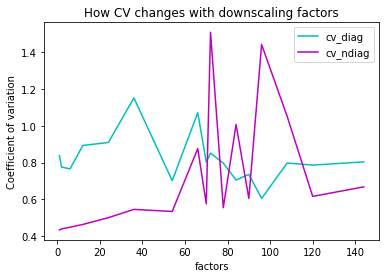

In [23]:
factorsList = [(1,1),(2,2),(6,6),(12,12),(24,24),(36,36),
               (54,54),(66,66),(70,70),(72,72),(78,78),
               (84,84),(90,90),(96,96),(108,108),(120,120),(144,144)]
factorNumber = np.array(factorsList).T[0]
l = []
for factors in factorsList:
    getChange = lambda frame,plane:getChangeTfAvg3(frame,plane,tf1,factors)
    s = getStats(getMatchScoreExtended,vids,nVids,1)
    l.append(s)
l = np.array(l).T
plt.plot(factorNumber,l[2],'c',label='cv_diag')
plt.plot(factorNumber,l[5],'m',label='cv_ndiag')
plt.legend(loc = "best")
plt.title("How CV changes with downscaling factors")
plt.xlabel("factors")
plt.ylabel("Coefficient of variation")
plt.show()

In the last 2 algorithms we have used 2 independent factors to seck the similarity between two video feeds. What if we combined those two factors. Algorithm 1 was more relatable to videos while 2 was more towards image recognition rather than that of  videos. Our 3rd Algo will be that.